# Example of Dataflow pipeline

This notebooks shows how you can use Dataflow to do distributed data processing.
In this case, the processing involves computing a statistical fit, something that is hard to do in SQL,
but quite straightforward in Python.

In [ ]:
!pip install google.cloud.bigquery

In [2]:
PROJECT='cloud-training-demos'  # CHANGE THIS
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

Let's get the duration of all the rides in a station

In [3]:
query = """
SELECT duration
FrOM `bigquery-public-data.london_bicycles.cycle_hire`
WHERE start_station_id = 708
"""
df = bq.query(query, location='EU').to_dataframe()
print(df.describe())

            duration
count   19112.000000
mean     1621.541440
std      8781.210736
min         0.000000
25%       360.000000
50%       720.000000
75%      1260.000000
max    687360.000000


Let's plot the distribution of these rides

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


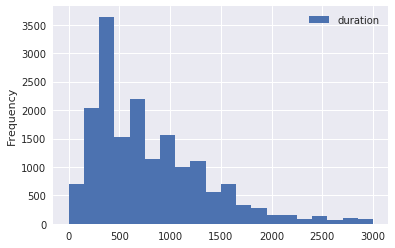

In [4]:
ax = df.plot.hist(range=[0, 3000], bins=20);

Fit to a Gamma distribution

In [5]:
from scipy import stats
ag,bg,cg = stats.gamma.fit(df['duration'])
print(ag, bg, cg)

7.297838861844789e-06 -6.485566100418746e-16 4.234333701782285


## The pipeline

In [ ]:
!python -m pip install --upgrade 'apache-beam[gcp]' 

In [8]:
%writefile requirements.txt
numpy
scipy

Overwriting requirements.txt


In [9]:
import apache_beam as beam
import logging
import datetime, os

PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
REGION='us-central1'

def compute_fit(row):
  from scipy import stats
  result = {}
  result['station_id'] = row['station_id']
  durations = row['duration_array']
  ag, bg, cg = stats.gamma.fit(durations)
  result['ag'] = ag
  result['bg'] = bg
  result['cg'] = cg
  return result

def run_job(in_test_mode=True):
  import shutil, os, subprocess
  job_name = 'compute_stats' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  
  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './station_stats'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/station_stats'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass
      
  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'requirements_file': 'requirements.txt'
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  
  if in_test_mode:
    query = """
      SELECT start_station_id as station, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      WHERE start_station_id BETWEEN 700 AND 710
      GROUP BY start_station_id
      """
  else:
     query = """
      SELECT start_station_id as station, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      GROUP BY start_station_id
      """

  with beam.Pipeline(RUNNER, options = opts) as p:
    (p 
      | 'read_bq' >> beam.io.Read(beam.io.BigQuerySource(query=query))
      | 'compute_fit' >> beam.Map(compute_fit)
      | 'write_bq' >> beam.io.gcp.bigquery.WriteToBigQuery(
          'ch05.station_stats', schema='station_id:string,ag:FLOAT64,bg:FLOAT64,cg:FLOAT64')
    )
    
run_job() #in_test_mode = False)

ImportError: No module named 'apache_beam'

In [38]:
dir(beam.io.gcp.bigquery)

['BigQueryDisposition',
 'BigQueryReader',
 'BigQuerySink',
 'BigQuerySource',
 'BigQueryWrapper',
 'BigQueryWriter',
 'DisplayDataItem',
 'GoogleCloudOptions',
 'HttpError',
 'JSON_COMPLIANCE_ERROR',
 'MAX_RETRIES',
 'RowAsDictJsonCoder',
 'TableRowJsonCoder',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '_parse_table_reference',
 'absolute_import',
 'auth',
 'bigquery',
 'coders',
 'collections',
 'dataflow_io',
 'datetime',
 'from_json_value',
 'json',
 'logging',
 'parse_table_schema_from_json',
 're',
 'retry',
 'time',
 'to_json_value',
 'uuid']